In [29]:
import pdfplumber
import random

pdf=pdfplumber.open("Stundenplan_MI.pdf")
page = pdf.pages[4]
table=page.extract_table({
"vertical_strategy": "lines_strict", 
"horizontal_strategy": "lines_strict",})

img=page.to_image()    
rects =  [ x for x in page.rects
        if x["width"] > 100 and x["width"] < 200 and x["height"]>30]

class Vorlesung:

    def __init__(self):
        self.tag = ""
        self.name = ""
        self.longname = ""
        self.dozent = ""
        self.raum = ""
        self.startBlock = ""
        self.endBlock = ""
        self.notes = ""

    def __str__(self):
        return (
            " "
            + self.name
            + ". "
            + self.dozent
            + ". "
            + self.raum
            + ". "
            + str(self.tag)
            + ". "
            + str(self.startBlock)
            + "-"
            + str(self.endBlock)
            + ". "
            + str(self.notes)
        )
def numberToDay(num):
    if abs(num-110)<5:
        return 'mo'
    elif abs(num-248)<5:
        return 'di'
    elif abs(num-385)<5:
        return 'mi'
    elif abs(num-523)<5:
        return 'do'
    elif abs(num-661)<5:
        return 'fr'

def numberToBlockstart(num):
    if abs(num-111)<5:
        return 1
    elif abs(num-172)<5:
        return 2
    elif abs(num-232)<5:
        return 3
    elif abs(num-294)<5:
        return 4
    elif abs(num-353)<5:
        return 5
    elif abs(num-413)<5:
        return 6
    elif abs(num-473)<5:
        return 7
    elif abs(num-534)<5:
        return 8


 CV_Pr. Ivanovska, Kestler. MBUT124. mo. 2-3. 
 CV_VL. Ivanovska. EMI113. mo. 4-4. 
 BAS. Rebholz. EMI002. di. 1-1. 
 APPP. Schäfer. DC107. di. 4-5. 
 INFSEC. Hirsch. EMI102. do. 2-3. 
 BLOCK. Neumann. EMI311. fr. 2-2. CertifiedTester&


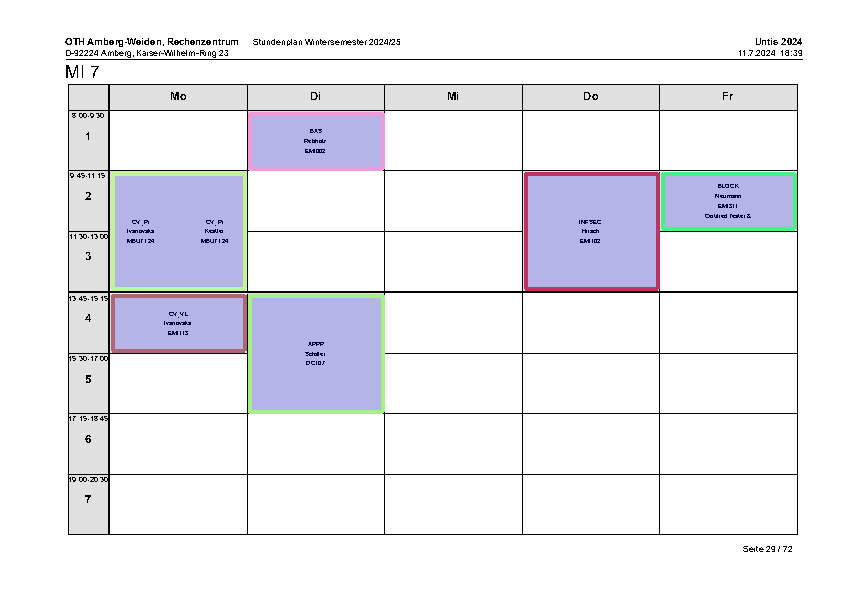

In [30]:
img.reset()
vls=[]
for rect in rects:
    img.draw_rect(rect,stroke_width=4,stroke=(random.randint(0,255), random.randint(0,255), random.randint(0,255)))
    box=(round(rect['x0']),round(rect['top']),round(rect['x1']),round(rect['bottom']))
    #print(box)
    
    cropt=page.crop(box, relative=True)
    text=cropt.extract_text().split()
    vl=Vorlesung()
    vl.startBlock=numberToBlockstart(box[1])
    vl.endBlock=numberToBlockstart(box[3])-1
    vl.tag=numberToDay(box[0])
    #print(text)
    if text[0]==text[1]:
        vl.name=text[0]
        vl.dozent=text[2]+", "+text[3]
        if text[4]==text[5]:
            vl.raum=text[4]
        else:
            vl.raum=text[4]+", "+text[5]
        if len(text)>6:
            vl.notes=text[6]
    else:
        vl.name=text[0]
        vl.dozent=text[1]
        vl.raum=text[2]
        if len(text)>3:
            vl.notes=text[3]
    print(vl)
    vls.append(vl)
 
display(img)